# Battle of the Neighbourhoods - Capstone Project Code

#### This notebook contains my code and thinking as I collect and wrangle the data required for answering the question set in my project.

Firstly in case the packages arent installed in the Jupyter Lab.

In [1]:
#!conda install -c conda-forge shapely -y #install shapely
#!conda install -c conda-forge folium=0.9.0 -y #update folium to version 0.9.0

Then I need to import all the required packages

In [2]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

import folium # mapping package
from folium import plugins # for adding the marker cluster

import matplotlib as mpl # plotting package
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
mpl.style.use(['ggplot'])

import requests # library to handle requests
import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # geo lookup

# import k-means from clustering stage
from sklearn.cluster import KMeans
# import shapely to do the geometry comparisons
from shapely.geometry import shape, GeometryCollection, Point

# Collecting the data from Foursquare

The first thing I am going to do is collect data from Foursquare, for this I have my API credentials. 
I also need to pass a version date as part of the call so I have chosen 01/10/2018 as this is past the last date of the updated categories list that I need. 

In [3]:
CLIENT_ID = 'XXXX' # your Foursquare ID
CLIENT_SECRET = 'XXXX' # your Foursquare Secret
VERSION = '20181001'

The Foursquare API function I am going to use is **explore**, this requires some additional parameters to be passed with the url as explained [here](https://developer.foursquare.com/docs/api/venues/explore).

1. The place I want the venues to be **near** is Singapore.
2. I want to be passed venues regardless of opening hours, so at *'any'* **time** of **day**.
3. I want it to give me a venue even if is not **open** at the time of the call. 

Then Foursquare has a **limit** of the number of venues it will pass in one call so I want to max this out at 100, and when there are more than 100 venues in a call, you can send the next call with an **offset** and get the next 100 on the list. However to start I need to with the offset being 0. 


In [4]:
near='Singapore'
time='any'
day='any'
isopen=0

LIMIT=100
offset=0

I have already searched through the [Foursquare categories](https://developer.foursquare.com/docs/resources/categories) list to pull the category IDs of the types that I think would be relevant to my project, I have come up with the following list. 

 - Café
 - Coffee Shop
 - Tea Room
 - Garden
 - Indoor Play Area
 - Park
 - Playground
 - Fair
 - Library
 - Doctor's Office
 - Nursery School
 - Preschool
 - Baby Store
 - Child Care Service
 - Daycare
 - Kids Store
 - Toy / Game Store
 - Museum
 
I then put those categories and their IDs into a csv file in my project data folder so I can easily read into a dataframe and use the data. 


In [5]:
# read data to dataframe
path = 'Data/4sqr-venue-types.csv'
cat_ids = pd.read_csv(path)

I now need to process through the categories list and get all of the venues, I have written two functions to accomplish this. 

The first one will parse through the categories list and output a dataframe, the second will take the category ID passed in and pull the data from the API, it also checks to see if there are more that 100 venues returned and the recursively calls itself with the offset increased by 100.

In [6]:
def getVenuesForCategories(categories, categoryIds):
    venues_list=[]
    for category, categoryId in zip(categories, categoryIds):
        print(category)
        venues_list = getCategoryVenues(categoryId, venues_list)
        
    category_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    category_venues.columns = ['venue', 
                  'category', 
                  'latitude', 
                  'longitude']
    
    return(category_venues)
        

def getCategoryVenues(categoryId, venue_list=[], offset=0):
            
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}\
&client_id={}&client_secret={}&near={}&v={}\
&limit={}&offset={}&time={}&day={}&openNow={}'.format(
        categoryId, 
        CLIENT_ID, 
        CLIENT_SECRET, 
        near, 
        VERSION, 
        LIMIT, 
        offset, 
        time, 
        day, 
        isopen)
            
    # make the GET request
    results = requests.get(url).json()
    total = int(results['response']['totalResults'])
    results = results['response']['groups'][0]['items']
    
    # check if more than 100 venues and recursively call function
    if (total - offset) > 100:
        print('Getting {} to {} of {}'.format(offset, str(min(offset+100, total)), total))
        venue_list = getCategoryVenues(categoryId, venue_list, offset+100)
    else:
        print('Getting {} to {} of {}'.format(offset, str(min(offset+100, total)), total))
        
    
    # return only relevant information for each nearby venue
    venue_list.append([(
        v['venue']['name'], 
        v['venue']['categories'][0]['name'],
        v['venue']['location']['lat'], 
        v['venue']['location']['lng']) for v in results])
    
    return venue_list

Calling the function with the category list as parameters, and pass into 'all_venues' dataframe. 

As it processes through it prints what category it's working on and the number of venues its getting. 

In [7]:
all_venues = getVenuesForCategories(categories=cat_ids['type'],
                               categoryIds=cat_ids['typeid'])

Café
Getting 0 to 100 of 359
Getting 100 to 200 of 359
Getting 200 to 300 of 359
Getting 300 to 359 of 359
Coffee Shop
Getting 0 to 100 of 284
Getting 100 to 200 of 284
Getting 200 to 284 of 284
Tea Room
Getting 0 to 100 of 111
Getting 100 to 111 of 111
Garden
Getting 0 to 100 of 182
Getting 100 to 182 of 182
Indoor Play Area
Getting 0 to 22 of 22
Park
Getting 0 to 100 of 283
Getting 100 to 200 of 283
Getting 200 to 283 of 283
Playground
Getting 0 to 100 of 165
Getting 100 to 165 of 165
Fair
Getting 0 to 28 of 28
Library
Getting 0 to 100 of 137
Getting 100 to 137 of 137
Doctor's Office
Getting 0 to 100 of 210
Getting 100 to 200 of 210
Getting 200 to 210 of 210
Nursery School
Getting 0 to 51 of 51
Preschool
Getting 0 to 45 of 45
Baby Store
Getting 0 to 29 of 29
Child Care Service
Getting 0 to 19 of 19
Daycare
Getting 0 to 14 of 14
Kids Store
Getting 0 to 77 of 77
Toy / Game Store
Getting 0 to 100 of 113
Getting 100 to 113 of 113
Museum
Getting 0 to 26 of 26


Lets also look at a sample of the dataframe

In [8]:
all_venues.sample(10)

,venue,category,latitude,longitude
1640,The Medical Clinic,Doctor's Office,1.284945,103.849719
996,Canopy Park,Park,1.359975,103.989905
424,Ya Kun Kaya Toast 亞坤,Café,1.283902,103.848024
5,Boufe Cafe,Restaurant,1.298104,103.814745
1723,Agape Little Uni @ Orange Grove,Preschool,1.313663,103.824920
982,East Coast Park BBQ Pit 20C,Park,1.299106,103.909972
1659,Synergy Orthopaedic Group,Doctor's Office,1.322245,103.844114
1848,Mini Princess,Kids Store,1.350462,103.848290
1533,Chin Choo Clinic,Doctor's Office,1.328915,103.886372
1931,Action Toyz,Toy / Game Store,1.263852,103.820202


Now I want to see how many venues I have got in total

In [9]:
all_venues.shape

(2041, 4)

This is quite a large number and because of some overlap in the venue categories I have requested I think there might be duplicates.

I will check by looking at the location data as there will definitely be venues with the same name but in different locations. 

In [10]:
all_venues[['latitude','longitude']].nunique()

latitude     1718
longitude    1714
dtype: int64

So this is saying there is over 300 venues that I have got that are duplicates.

We can find and drop those

In [11]:
all_venues.sort_values(by=['venue'], inplace=True)
all_venues.drop_duplicates(subset=['latitude','longitude'], keep='last', inplace=True)
all_venues.reset_index(inplace=True, drop=True)
all_venues.shape

(1720, 4)

Now we are down to 1720 venues, I am going to plot them on a map of Singapore so we can see the spread around the city. 

Before I do this I know the Folium library doesnt like apostrophes (') or quotes (") in the data so I am going to blanket remove them from the dataframe

In [12]:
all_venues['venue'] = all_venues['venue'].str.replace("'", "")
all_venues['venue'] = all_venues['venue'].str.replace('"', "")
all_venues['category'] = all_venues['category'].str.replace("'", "")
all_venues.head(10)

,venue,category,latitude,longitude
0,The New World Gate,Park,1.311800,103.855613
1,10 10 Mother & Child Essential,Baby Store,1.406066,103.901610
2,10 10 Mother & Child Esssential,Baby Store,1.391520,103.876270
3,10 Scotts,Tea Room,1.306648,103.833125
4,172 Roof Garden,Garden,1.395484,103.911808
5,18 Clinic,Doctors Office,1.319412,103.861501
6,21st Century Competencies Hub,Library,1.301314,103.784381
7,26th Storey Sky Garden,Garden,1.277516,103.841625
8,276 Cafe,Coffee Shop,1.353928,103.703415
9,299C Compassvale Street Playground Near RC,Playground,1.395851,103.902235


Lets put the data for the map into another dataframe.

In [13]:
map_df = all_venues

Ok, so I am going to create a map of Singapore centred around the centre of the island. 

Then I will create a Marker Cluster that will group together all the venues, and as the user zooms into and out of the map, the clusters will split and rejoin again. 

In [14]:
# create map of Singapore using latitude and longitude values
sing_lat=1.351616
sing_lon=103.808053
map_sing = folium.Map(location=[sing_lat, sing_lon], zoom_start=12)

# instantiate a mark cluster object for the incidents in the dataframe
venues = plugins.MarkerCluster().add_to(map_sing)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, venue, category in zip(
    map_df['latitude'], 
    map_df['longitude'], 
    map_df['venue'], 
    map_df['category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(html=label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(venues)

# display map
map_sing

# Planning Areas of Singapore

Singapore is demarcated into Planning Areas, and this project will ultimately suggest a planning area that best suits the requirements of the hypothetical scenario. So I will need to determine which planning area each of the venues is located in. The planning area is part of the government master plan for ensuring development and so they are not baked into the countries address system. I have found a geojson file of all the planning areas and will import that using Shapely to perform the query. 

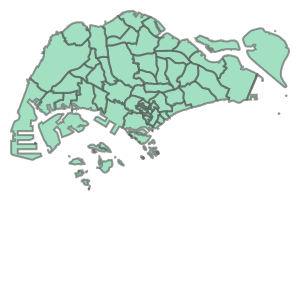

In [15]:
with open("Data/sing-areas.geojson") as f:
    features = json.load(f)["features"]

sing_geo_coll = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

import pyproj
from shapely.ops import transform
from functools import partial

proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3414'))

sing_geo_coll_new = transform(proj, sing_geo_coll)
sing_geo_coll_new

I want to create a dataframe of all the planning areas and their names and also their centroid locations so I can see later on which is closest to the IBM Office. 

The code parses through the json and pulls out the area names and finds the centroid coordinates and places into lists, it also places the geometry of the polygon into the last list so I can use it later for seeing which planning area each venue is located in.

In [16]:
region = []
plan_area = []
centroidx = []
centroidy = []
geometry = []

i = 0
while(i != len(features)):
    region.append(features[i]['properties']['Region Name'])
    plan_area.append(features[i]['properties']['Planning Area Name'])
    mypoly = shape(features[i]['geometry'])
    centroidx.append(mypoly.centroid.x)
    centroidy.append(mypoly.centroid.y)
    geometry.append(features[i]['geometry'])
    i = i + 1

Now I can build a dataframe from the lists

In [17]:
sing_df = pd.DataFrame(columns=['region', 'planning_area','centroid_x', 'centroid_y', 'coordinates'])

sing_df['region'] = region
sing_df['planning_area'] = plan_area
sing_df['centroid_x'] = centroidx
sing_df['centroid_y'] = centroidy
sing_df['coordinates'] = geometry

sing_df.head()

,region,planning_area,centroid_x,centroid_y,coordinates
0,CENTRAL REGION,BUKIT MERAH,103.823127,1.275491,"{'type': 'MultiPolygon', 'coordinates': [[[[10..."
1,WEST REGION,CHOA CHU KANG,103.747191,1.385556,"{'type': 'MultiPolygon', 'coordinates': [[[[10..."
2,CENTRAL REGION,BUKIT TIMAH,103.790698,1.329989,"{'type': 'MultiPolygon', 'coordinates': [[[[10..."
3,NORTH REGION,CENTRAL WATER CATCHMENT,103.801189,1.376655,"{'type': 'MultiPolygon', 'coordinates': [[[[10..."
4,EAST REGION,CHANGI,103.997823,1.350806,"{'type': 'MultiPolygon', 'coordinates': [[[[10..."


I want to parse through the venues list and for each venue, pull out the location data, then compare this to each planning area polygon, once it has found which planning area the venue is located in then it can break out and move onto the next venue. If it doesnt find a planning area where then it will set a 'NONE' into that place in the list. 

In [18]:
area = []

for i, row in all_venues.iterrows():
    area.insert(i, "NONE")
    for j, row in sing_df.iterrows():
        plan_area = shape(sing_df.loc[j,'coordinates'])
        lat = all_venues.loc[i,'latitude']
        lon = all_venues.loc[i,'longitude']
        location = Point(lon, lat)
        if plan_area.contains(location):
            area[i] = sing_df.loc[j,'planning_area']
            break
    i = i + 1

Now I want to find any instances of a venue not being assigned an area

In [19]:
all_venues['area'] = area
all_venues[all_venues['area']=='NONE']

,venue,category,latitude,longitude,area
713,Labrador Nature & Coastal Walk,Park,1.265728,103.807240,NONE
1075,Punggol Beach,Beach,1.420425,103.913108,NONE


There are 2 places that have not being captured inside an area, and having checked the map, I can see this is because the coordinates are slightly outside all of the geojson polygons. However I know where those places are and so will manually assigned them to their respective planning areas. 

In [20]:
all_venues.loc[713,'area']='BUKIT MERAH'
all_venues.loc[1075,'area']='PUNGGOL'

Now we have all the venues and their areas, we can group the dataframe by the areas and see a total count of number of venues in each area. 

In [21]:
venue_count = all_venues.groupby(['area']).size().reset_index(name='venue_count')
venue_count.head(10)

,area,venue_count
0,ANG MO KIO,35
1,BEDOK,53
2,BISHAN,45
3,BOON LAY,2
4,BUKIT BATOK,19
5,BUKIT MERAH,86
6,BUKIT PANJANG,24
7,BUKIT TIMAH,50
8,CENTRAL WATER CATCHMENT,12
9,CHANGI,50


Lets plot the count of venues on a Choropleth map overlayed on Singapore with the planning areas highlighted

In [22]:
sing_geo = r'Data/sing-areas.geojson' # geojson file

# create a plain singapore map
m = folium.Map(location=[1.351616, 103.808053], zoom_start=12, tiles='mapboxbright')

# add a Choropleth map with venue counts determining colour 
folium.Choropleth(
    geo_data=sing_geo,
    data=venue_count,
    columns=['area','venue_count'],
    key_on='feature.properties.Name',
    bins=8,
    fill_color='YlGnBu',
    nan_fill_color='black',
    fill_opacity=0.7, 
    nan_fill_opacity=None,
    line_opacity=0.2,
    legend_name='Count of Venues',
    highlight=True,
    name='area'
).add_to(m)

# add an overlay of highlighting and the Area Name when hovering over the polygon
folium.GeoJson(data=sing_geo,
               name='Name',
               style_function=lambda x: {'color':'black','fillColor':'transparent','weight':2},
               tooltip=folium.GeoJsonTooltip(fields=['Name'],
                                            labels=False,
                                            sticky=False),
               highlight_function=lambda x: {'weight':3,'fillColor':'grey'}
).add_to(m)

# Choropleth maps have an issue rendering in Jupyter Lab and so I will save the map to html
# and then embed the map in an iFrame
def embed_map(m):
    from IPython.display import IFrame

    m.save('choromap.html')
    return IFrame('choromap.html', width='100%', height='750px')

# display map
embed_map(m)

Any area highlighted in black has no venues located inside it, we are going to want to focus on the ones in blue or green. 

I am looking to narrow down my selection to places with a high number of places to visit and things to do. So I am going to ask for just the top 10 highest count of venues in planning areas. 

I will create a shortlist of this top 10 areas for use later

In [23]:
venue_count = venue_count.sort_values('venue_count', ascending=False).reset_index(drop=True)
area_shortlist = venue_count['area'][:10]
area_shortlist

0    DOWNTOWN CORE
1          ORCHARD
2      BUKIT MERAH
3         TAMPINES
4       QUEENSTOWN
5      JURONG EAST
6            BEDOK
7          TANGLIN
8      BUKIT TIMAH
9           CHANGI
Name: area, dtype: object

Lets take this shortlist on and try to narrow it down some more

# Commuting Distance

Having things to do with a young family is important where you live, however so is time spent commuting. The quicker you can get to work and back the longer you get to spend with your family. So we want to see how close each area is to the office. 

For the purposes of this hypothetical I have imagined working as a Data Scientist at IBM, so I am need to find the location of the IBM Office. 

In [24]:
#Find the coordinates of the IBM Building
address = '9 Changi Business Park Central 1, Singapore'

geolocator = Nominatim(user_agent="sing_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of the IBM Building in Singapore are {}, {}.'.format(latitude, longitude))

The geographical coordinates of the IBM Building in Singapore are 1.3364564, 103.965171066805.


Now we know where we are looking to work, lets see how far each of the top 10 shortlisted areas are from here. 

I will pull in the centroid coordinates of those in the shortlist. 

In [25]:
top10 = sing_df[sing_df['planning_area'].isin(area_shortlist)]
top10 = top10.drop(['region','coordinates'], axis=1)
top10.reset_index(inplace=True, drop=True)
top10

,planning_area,centroid_x,centroid_y
0,BUKIT MERAH,103.823127,1.275491
1,BUKIT TIMAH,103.790698,1.329989
2,CHANGI,103.997823,1.350806
3,BEDOK,103.928409,1.324047
4,DOWNTOWN CORE,103.854301,1.285065
5,ORCHARD,103.833580,1.303807
6,JURONG EAST,103.734796,1.320444
7,QUEENSTOWN,103.784559,1.289073
8,TAMPINES,103.954260,1.343656
9,TANGLIN,103.817595,1.308374


Now lets calculate the distance in kms to the office from the centroid locations of each area. 

In [27]:
#Find direct distance from top 10 areas to the office
import math

point1 = Point(longitude, latitude)
distance= []
for i, row in top10.iterrows():
    lat = top10.loc[i,'centroid_y']
    lon = top10.loc[i,'centroid_x']
    point2 = Point(lon, lat)
    dis = math.acos(math.sin(math.radians(point1.y))*math.sin(math.radians(point2.y))+math.cos(math.radians(point1.y))*math.cos(math.radians(point2.y))*math.cos(math.radians(point2.x)-math.radians(point1.x)))*6371
    distance.append("{0:8.2f}".format(dis))
    
distance

['   17.18',
 '   19.41',
 '    3.96',
 '    4.31',
 '   13.59',
 '   15.07',
 '   25.67',
 '   20.76',
 '    1.45',
 '   16.70']

And add that column to the top 10 dataframe and then sort by lowest distance. 

In [28]:
top10['km_to_IBM'] = distance
top10.sort_values('km_to_IBM')

,planning_area,centroid_x,centroid_y,km_to_IBM
8,TAMPINES,103.954260,1.343656,1.45
2,CHANGI,103.997823,1.350806,3.96
3,BEDOK,103.928409,1.324047,4.31
4,DOWNTOWN CORE,103.854301,1.285065,13.59
5,ORCHARD,103.833580,1.303807,15.07
9,TANGLIN,103.817595,1.308374,16.70
0,BUKIT MERAH,103.823127,1.275491,17.18
1,BUKIT TIMAH,103.790698,1.329989,19.41
7,QUEENSTOWN,103.784559,1.289073,20.76
6,JURONG EAST,103.734796,1.320444,25.67


We can see that some places that are in the shortlist are close, lets build a map and add lines and markers on to show the distance. 

In [29]:
dist_map = folium.Map(location=[1.351616, 103.808053], zoom_start=12)

folium.Marker(
    [latitude, longitude],
    popup = 'IBM Office').add_to(dist_map)

for lat, lng, area, dist in zip(top10['centroid_y'], 
                           top10['centroid_x'], 
                           top10['planning_area'],
                           top10['km_to_IBM']
                                   ):
    label = '{}, {}'.format(area, dist+"km")
    #label = folium.Popup(label, parse_html=True),
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(dist_map)
    folium.PolyLine(
        locations=[(latitude,longitude),(lat,lng)],
        line_opacity=0.7).add_to(dist_map)

    
def embed_map1(m):
    from IPython.display import IFrame

    m.save('distmap.html')
    return IFrame('distmap.html', width='100%', height='750px')

# display map
embed_map1(dist_map)

 - Tampines
 - Bedok
 - Changi 
 
These areas in the shortlist and are the closest to the IBM Office. 

# Rental Prices

Beyond the distance and number of things to do, cost is also an important factor in the decision process. I want to make sure that the area is within the housing allowance budget. 

I have imported a data set of the median flat prices across Singapore for all the room sizes, lets interrogate the data a bit.

In [30]:
path = 'Data/median-rent-by-town-and-flat-type.csv'
rent_df = pd.read_csv(path)
rent_df.sample(5)

,quarter,town,flat_type,median_rent
5740,2014-Q2,JURONG WEST,2-RM,-
5039,2013-Q1,YISHUN,1-RM,na
681,2006-Q2,BUKIT PANJANG,4-RM,-
3865,2011-Q2,HOUGANG,2-RM,na
34,2005-Q2,BUKIT PANJANG,5-RM,-


I need to convert the quarter column into a date and change the rent column into float. I can also make the flat type column into a category type to help quickly remove unwanted values. 

In the scenario we want at least a 3 bedroom flat so I can remove the 1 and 2 bedroom options. 

In [31]:
rent_df = rent_df.rename(columns={"quarter": "date"})
rent_df['date']= rent_df['date'].map(lambda x: x.replace('-', ''))
rent_df['date'] = pd.PeriodIndex(pd.to_datetime(rent_df['date'], errors='coerce'), freq='Q')
rent_df['median_rent'].replace('na', np.nan, inplace=True)
rent_df['median_rent'].replace('-', np.nan, inplace=True)
rent_df['median_rent'] = rent_df['median_rent'].astype('float64')
rent_df["flat_type"] = rent_df["flat_type"].astype("category")
rent_df["flat_type"].cat.set_categories(["3-RM","4-RM","5-RM", 'EXEC'],inplace=True)
rent_df.dropna(subset=['flat_type'], inplace=True)
rent_df.sample(5)

,date,town,flat_type,median_rent
4460,2012Q2,BUKIT TIMAH,4-RM,NaN
8201,2018Q2,CENTRAL,3-RM,2150.0
8435,2018Q3,SENGKANG,3-RM,NaN
6920,2016Q2,BEDOK,EXEC,2600.0
7223,2016Q4,ANG MO KIO,3-RM,1800.0


Let's see what the average price of all of the different flat types across Singapore has been over the last 20 years

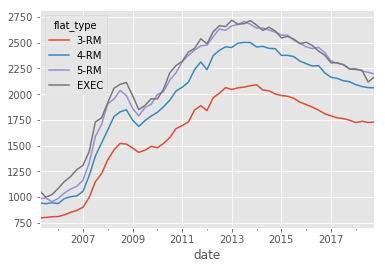

In [32]:
avg_rent = rent_df.groupby(['date', 'flat_type'])['median_rent'].mean().unstack()
avg_rent.plot(kind='line')

Flat prices are coming down from a peak in 2013 and are flattening out, it looks like 3 bedroom places are quite a lot cheaper than the other types, this could be because that is the most popular type of flat and so there is a larger range of prices for the median to be calculated over. Also Executive and 5 bedroom places are fairly similarly priced at the top end of the market. 

Lets look specifically at the shortlisted areas, unfortunately the areas don't match exactly so I will have to make a few substitutions 

In [33]:
substitutions = {"KALLANG": "KALLANG/WHAMPOA", "DOWNTOWN CORE": "CENTRAL", "ORCHARD": "CENTRAL"}
rental_shortlist = area_shortlist.replace(substitutions)

short_df = rent_df[rent_df['town'].isin(rental_shortlist)]
short_df.head()

,date,town,flat_type,median_rent
8,2005Q2,BEDOK,3-RM,800.0
9,2005Q2,BEDOK,4-RM,900.0
10,2005Q2,BEDOK,5-RM,1025.0
11,2005Q2,BEDOK,EXEC,NaN
26,2005Q2,BUKIT MERAH,3-RM,850.0


Lets plot the average flat prices for just the shortlisted areas

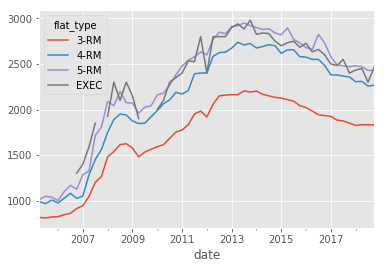

In [34]:
avg_df = short_df.groupby(['date', 'flat_type'])['median_rent'].mean().unstack()
avg_df.plot(kind='line')

Not much change from the full list for 3 room places but the 4+ room places have increased in price. 

Lets look at just 4 room as it would be nice to see if we can get a larger place, I want the data from 2009 to now for each area in the shortlist that we have data for. 

In [35]:
pivot_df = short_df[(short_df['date']>2009) & (short_df['flat_type']=='4-RM')]
pivot_df.reset_index(drop=True, inplace=True)
pivot_df.sample(5)

,date,town,flat_type,median_rent
141,2014Q2,BUKIT MERAH,4-RM,2900.0
31,2010Q2,CENTRAL,4-RM,2400.0
65,2011Q3,BUKIT TIMAH,4-RM,NaN
156,2014Q4,BUKIT TIMAH,4-RM,NaN
64,2011Q3,BUKIT MERAH,4-RM,2600.0


Now lets pivot the table so that each area gets its own column.

In [36]:
pivot = pivot_df.pivot_table(index='date', columns='town', values='median_rent')
pivot.head()

town,BEDOK,BUKIT MERAH,BUKIT TIMAH,CENTRAL,JURONG EAST,QUEENSTOWN,TAMPINES
date,,,,,,,
2009Q2,1630.0,2000.0,NaN,NaN,1750.0,2150.0,1700.0
2009Q3,1700.0,2000.0,NaN,NaN,1800.0,2050.0,1700.0
2009Q4,1700.0,2160.0,NaN,NaN,1800.0,2140.0,1800.0
2010Q1,1700.0,2200.0,NaN,2300.0,1800.0,2130.0,1800.0
2010Q2,1800.0,2200.0,NaN,2400.0,1830.0,2300.0,1850.0


Now plot the data

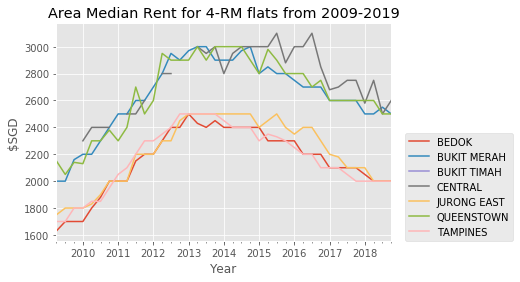

In [37]:
pivot.plot(kind='line')
plt.legend(loc=(1.04,0))
plt.title('Area Median Rent for 4-RM flats from 2009-2019')
plt.ylabel('$SGD')
plt.xlabel('Year')
plt.show()

It looks like the 4-Room places are split into 2 prices, Central, Queenstown and Bukit Merah are above $\$$2500 SGD but Bedok, Jurong East and Tampines are more reasonable at $\$$2000 SGD

Tampines and Bedok were also in the shortlist for distance to the office, so I think they are the best options right now. 

# Population

I wanted to utilise some machine learning techniques in my project and I thought that clustering along population distributions would be an interesting option. The data is from the last Singapore census in 2015 and contains total population of the 4 main ethnic groups; Chinese, Malay, Indian, and Others, for each planning area. 

As most expats will fall into the 'Others' category I wanted to see if there are clusters of expat communities in certain areas of Singapore. While this shouldn't influence the decision of where to live, it might show other areas of Singapore that were not originally in the options. 

In [38]:
pop_df = pd.read_csv('Data/ethnicpopbyarea.csv')
pop_df['area'] = pop_df['area'].str.upper()
pop_df.head()

,area,chinese,malays,indians,others,total
0,BEDOK,"208,880","43,980","25,110","11,780","289,750"
1,TAMPINES,"175,470","56,010","21,560","8,200","261,230"
2,JURONG WEST,"190,240","48,630","27,090","6,710","272,660"
3,WOODLANDS,"153,780","62,310","27,810","6,380","250,290"
4,BUKIT TIMAH,"64,150",760,"3,650","5,910","74,470"


I want to set the index of the dataframe to be the name of the area.

In [39]:
pop_df = pop_df.set_index('area')
pop_df = pop_df.drop('total', axis=1)
pop_df.head()

,chinese,malays,indians,others
area,,,,
BEDOK,"208,880","43,980","25,110","11,780"
TAMPINES,"175,470","56,010","21,560","8,200"
JURONG WEST,"190,240","48,630","27,090","6,710"
WOODLANDS,"153,780","62,310","27,810","6,380"
BUKIT TIMAH,"64,150",760,"3,650","5,910"


The data is not in a numeric format so lets remove the thousands comma and convert the columns to integers. 

In [40]:
pop_df = pop_df.stack().str.replace(',','').unstack()
pop_df[['chinese','malays','indians','others']] = pop_df[['chinese','malays','indians','others']].apply(pd.to_numeric)
pop_df.dtypes

chinese    int64
malays     int64
indians    int64
others     int64
dtype: object

Now we need to preprocess the data by transforming it into normalised values. 

In [41]:
from sklearn.preprocessing import StandardScaler

X = pop_df.values[:,1:]
X = np.nan_to_num(X)
cluster_dataset = StandardScaler().fit_transform(X)
cluster_dataset

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.90532059e+00,  2.00766617e+00,  3.38993312e+00],
       [ 2.64574091e+00,  1.56877123e+00,  1.98057758e+00],
       [ 2.19151797e+00,  2.25245828e+00,  1.39400223e+00],
       [ 3.03349220e+00,  2.34147359e+00,  1.26408957e+00],
       [-7.54776349e-01, -6.45484642e-01,  1.07906244e+00],
       [ 9.47636455e-01,  3.76955118e-01,  9.72770265e-01],
       [ 1.28738044e+00,  1.40434017e+00,  9.21592550e-01],
       [ 5.88197164e-01,  1.15336645e+00,  8.42857603e-01],
       [ 2.84766393e-01,  1.13358527e+00,  6.93261205e-01],
       [ 1.02210932e+00,  9.39482435e-01,  6.38146742e-01],
       [ 2.31881426e-02,  7.72578725e-01,  6.06652763e-01],
       [ 2.26188252e-03,  6.52655320e-01,  4.33435881e-01],
       [-2.64855672e-01, -1.07683801e-01,  3.07459966e-01],
       [ 4.02938215e-01,  6.00729721e-01,  2.87776230e-01],
       [ 1.38898051e-01,  1.27217716e-01,  2.20851525e-01],
       [-1.90998284e-01,  5.18019661e-02,  1.34243084e-01],
       [-1.89151849e-01, -1.57136751e-01

Finally lets cluster the areas into 4 groups 

In [42]:
num_clusters = 4

k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(cluster_dataset)
labels = k_means.labels_

print(labels)

[2 2 2 2 1 3 3 3 3 3 3 3 1 3 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0]


Assign the grouping labels to a column in the datraframe

In [43]:
pop_df["labels"] = labels
pop_df.sample(5)

,chinese,malays,indians,others,labels
area,,,,,
QUEENSTOWN,77390,8720,8000,3950,1
YISHUN,142300,33940,20230,5510,3
SOUTHERN ISLANDS,810,20,150,500,0
BUKIT TIMAH,64150,760,3650,5910,1
NOVENA,38840,2110,4210,2830,1


In [44]:
pop_df.groupby('labels').mean()

,chinese,malays,indians,others
labels,,,,
0,4588.571429,272.857143,727.857143,610.000000
1,74032.857143,9137.857143,8230.000000,3292.142857
2,182092.500000,52732.500000,25392.500000,8267.500000
3,133741.250000,22281.250000,15982.500000,4882.500000


Lets see what cluster Tampines has been assigned to.

In [45]:
pop_df.loc['TAMPINES','labels']

2

Now lets see all areas that are in the same cluster as Tampines

In [46]:
pop_df[pop_df['labels']==pop_df.loc['TAMPINES','labels']]

,chinese,malays,indians,others,labels
area,,,,,
BEDOK,208880,43980,25110,11780,2
TAMPINES,175470,56010,21560,8200,2
JURONG WEST,190240,48630,27090,6710,2
WOODLANDS,153780,62310,27810,6380,2


I need to add the labels to the sing_df dataframe

In [47]:
sing_df['labels'] = sing_df['planning_area'].map(pop_df['labels'].to_dict())
sing_df.head()

,region,planning_area,centroid_x,centroid_y,coordinates,labels
0,CENTRAL REGION,BUKIT MERAH,103.823127,1.275491,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",3.0
1,WEST REGION,CHOA CHU KANG,103.747191,1.385556,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",3.0
2,CENTRAL REGION,BUKIT TIMAH,103.790698,1.329989,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",1.0
3,NORTH REGION,CENTRAL WATER CATCHMENT,103.801189,1.376655,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",NaN
4,EAST REGION,CHANGI,103.997823,1.350806,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",0.0


Now to convert the labels type to integer64 and because the map markers wont be able to handle NaN, I will increase the label number for each by 1 and replace the NaN with 0.

In [48]:
sing_df['labels'] = sing_df['labels'].astype('Int64')
sing_df['labels'] = sing_df['labels'] + 1
sing_df['labels'] = sing_df['labels'].replace(np.nan, 0)
sing_df.head()

,region,planning_area,centroid_x,centroid_y,coordinates,labels
0,CENTRAL REGION,BUKIT MERAH,103.823127,1.275491,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",4
1,WEST REGION,CHOA CHU KANG,103.747191,1.385556,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",4
2,CENTRAL REGION,BUKIT TIMAH,103.790698,1.329989,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",2
3,NORTH REGION,CENTRAL WATER CATCHMENT,103.801189,1.376655,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",0
4,EAST REGION,CHANGI,103.997823,1.350806,"{'type': 'MultiPolygon', 'coordinates': [[[[10...",1


Lets see the clusters across Singapore on a map

In [49]:
# create map
map_clusters = folium.Map(location=[1.351616, 103.808053], zoom_start=11)

# set color scheme for the clusters
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.viridis(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sing_df['centroid_y'], sing_df['centroid_x'], sing_df['planning_area'], sing_df['labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

So the clustering is saying that with Tampines, Bedok next door and also Jurong West and Woodlands are similar when it comes to population ethnicity proportions. 